In [1]:
library("readxl")

Warning message:
"package 'readxl' was built under R version 3.6.3"

In [2]:
library("lubridate")

Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following objects are masked from 'package:base':

    date, intersect, setdiff, union



In [3]:
search()

[1] ".GlobalEnv"        "package:lubridate" "package:readxl"   
 [4] "jupyter:irkernel"  "jupyter:irkernel"  "package:stats"    
 [7] "package:graphics"  "package:grDevices" "package:utils"    
[10] "package:datasets"  "package:methods"   "Autoloads"        
[13] "package:base"

In [4]:
source("helpers.R")

In [5]:
path <- "../data/data.xlsx"

In [6]:
df <- Dataframing(path)

In [7]:
df <- df[-c(210),]

In [8]:
df$Date <- as.Date(df$Date)

In [9]:
firstYields <- df[df$Date == "2022-02-11",]

In [10]:
firstYields

,Date,10Y,7Y,5Y,3Y,2Y,1Y,6M,3M
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
209,2022-02-11,1.941,1.94,1.856,1.728,1.505,1.029,0.692,0.359


#### Suponemos que: 
- $\alpha_1$ representa la tasa forward entre 0 y 3 meses, 
- $\alpha_2$ la tasa entre 3 meses y 1 año, 
- $\alpha_3$ la tasa entre 1 y 3 años,
- $\alpha_4$ la tasa entre 3 y 5 años ,
- $\alpha_5$ la tasa entre 5 y 10 años. 

In [11]:
today <- firstYields$Date

#### Además, para traer a valor presente usando una curva forward, se sigue el factor de descuento a un plazo T es: 

### $$ e^{-\int_{0}^{T} f(t) \,dt}$$

#### Definamos algunos objetos de utilidad. Cuántos cupones paga cada bono? Cómo ajustamos la tasa para cada pago?

In [12]:
alpha <- c(0.1,0.11,0.12,0.13,0.14)

In [13]:
alpha

[1] 0.10 0.11 0.12 0.13 0.14

In [14]:
today = firstYields$Date

In [15]:
threeMonthBond <- 100 + RateConverter(firstYields[["3M"]],3,today)*DiscountFactor(alpha, 3)
threeMonthBond
RateConverter(firstYields[["3M"]],3,today)
RateConverter(0.359,3,today)
RateConverter(firstYields[["1Y"]],12,today)


[1] 100.04

[1] 0.04097994

[1] 0.04097994

[1] 0.4303246

In [16]:
sixMonthBond <- 100 + RateConverter(firstYields[["6M"]], 6, today)*DiscountFactor(alpha, 6)

In [17]:
sixMonthBond

[1] 100.1435

In [18]:
oneYearBond <- 100 +  RateConverter(firstYields[["1Y"]], 6, today) *DiscountFactor(alpha, 6) + RateConverter(firstYields[["1Y"]], 12, today)*DiscountFactor(alpha, 12)

In [19]:
oneYearBond

[1] 100.5889

In [20]:
maturity<- 36

In [21]:
periods <- seq(6, maturity, 6)

In [22]:
threeMonthBond

[1] 100.04

Recordemos que cada pago está dado por :  

$$\$100\times R \times \frac{ACT}{360}$$

In [23]:
singleBondPayment <- function(maturity, yield, alpha, today){
    return (RateConverter(yield, maturity,today)*DiscountFactor(alpha, maturity))
}

In [24]:
singleBondPayment(120,firstYields[["10Y"]], alpha, today)
firstYields[["10Y"]]

[1] 1.961799

[1] 1.941

In [25]:
yieldList <- list(firstYields)

In [26]:
nombres <- colnames(firstYields)

In [27]:
nombres <- nombres[-1]

In [28]:
nombres

[1] "10Y" "7Y"  "5Y"  "3Y"  "2Y"  "1Y"  "6M"  "3M"

In [29]:
nombres <- as.list(nombres)

In [30]:
names(nombres) <- c(120,84,60,36,24,12,6,3) 

In [31]:
BondValue <- function (today, maturity, yieldlist,alpha ){
    if (maturity == 3){
        return (100*DiscountFactor(alpha, maturity) + singleBondPayment(3,yieldlist[["3M"]], alpha, today))
        }
    setter <- as.character(maturity)
    periods <- seq(6, maturity, 6)
    bondSum <- sum(unlist(lapply(periods, function(x) singleBondPayment(x, yield = yieldlist[[nombres[[setter]]]],  alpha = alpha, today = today))))
    return(bondSum +100*DiscountFactor(alpha, maturity))
}



In [32]:
BondValue(today, 120, firstYields, alpha)

[1] 60.82667

In [33]:
maturities <- c(120,84,60,36,24,12,6,3) 

In [34]:
alpha <- c(0.00343939424789704, 0.0105322205923502, 0.0817121232717679, 0.159800322624318, 0.274481567907549)
bondValues <- list()
for (i in maturities){
    bondValues <- append(bondValues, BondValue(today, i, firstYields, alpha))
}

In [35]:
bondValues

[[1]]
[1] 46.99011

[[2]]
[1] 58.44332

[[3]]
[1] 75.90361

[[4]]
[1] 90.42945

[[5]]
[1] 94.14811

[[6]]
[1] 99.76715

[[7]]
[1] 99.80201

[[8]]
[1] 99.955

In [36]:
error <-function(alpha){
    maturities <- c(3,6,12,24,36,60,84,120) 
    bondValues <- list()
    for (i in maturities){
        bondValues <- append(bondValues, BondValue(today, i, firstYields, alpha))
    }
    error <- sum((unlist(bondValues)-100)**2)
    return (error)
}

error(alpha)

[1] 5243.577

In [37]:
opt <- optim(alpha, error, lower = 0, upper= 1, method = "L-BFGS-B")

In [38]:
list(opt$par)

[[1]]
[1] 0.001531767 0.004526182 0.031085059 0.057262393 0.108576414

Valoración de bono de 7 años

In [39]:
alpha <- opt$par
pvnotional <- 100 - DiscountFactor(alpha[4], 84)*100
pvnotional
couponsum <- function (c){
pvcoupon <- DiscountFactor(alpha[2], 12)*RateConverter(c, 12,today) + DiscountFactor(alpha[2], 24)*RateConverter(c,24,today) +
 DiscountFactor(alpha[3], 36)*RateConverter(c, 36,today) +DiscountFactor(alpha[3], 48)*RateConverter(c, 48,today) +
 DiscountFactor(alpha[4], 60)*RateConverter(c, 60,today) + DiscountFactor(alpha[4], 72)*RateConverter(c, 72,today) +  
 DiscountFactor(alpha[4], 84)*RateConverter(c, 84,today) + DiscountFactor(alpha[4], 84)*RateConverter(c, 84,today)
 result <-pvnotional- pvcoupon
    if (result <0){
        return (500)
    }
    else {
        return (pvnotional- pvcoupon)
    }
    
}

opti <- optim(c,couponsum,lower = 0, upper=10,  method = "Brent")
opti


[1] 33.02406

$par
[1] 3.938981

$value
[1] 5.759138e-07

$counts
function gradient 
      NA       NA 

$convergence
[1] 0

$message
NULL

Matriz de curvas 3 años en el pasado

In [40]:

matAlphas <- list()
for ( r in 1:nrow(df)){ 
    firstYields <- df[r,]
    today <- firstYields$Date
    alpha <- opt$par
    opt <- optim(alpha, error, lower = 0, upper= 1, method = "L-BFGS-B")
    matAlphas <- append(matAlphas, list(opt$par))
}

In [41]:
MatofAlphas <- matrix(unlist(matAlphas), ncol = 5, byrow = TRUE)
MatofAlphas

0.005732163,0.008365817,0.03855734,0.07573650,0.1468967
0.005730203,0.008736903,0.03855725,0.07507592,0.1466868
0.005839715,0.008947748,0.03867916,0.07533730,0.1464051
0.006065502,0.008683511,0.03920832,0.07553581,0.1475984
0.006369937,0.008852003,0.03931360,0.07509871,0.1450026
0.006215890,0.008743961,0.03883230,0.07407387,0.1441879
0.005984790,0.009340253,0.03840258,0.07313997,0.1408319
0.006007077,0.009013525,0.03870613,0.07358605,0.1422060
0.006180894,0.009123558,0.04001447,0.07530378,0.1434042
0.006240368,0.009472351,0.04139540,0.07826057,0.1480469
0.006123415,0.009823279,0.04133481,0.07836993,0.1478789


In [42]:
write.csv(MatofAlphas,"../data/sim.csv", row.names = FALSE)

In [43]:
MatofAlphas <- read.csv("../data/sim.csv")
i_alpha <- MatofAlphas[-nrow(MatofAlphas),]
f_alpha <- MatofAlphas[-1,]
delta_alpha <- f_alpha - i_alpha
cov_delta_a <- cov(delta_alpha)
MatofAlphas
cov_delta_a

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.005732163,0.008365817,0.03855734,0.07573650,0.1468967
0.005730203,0.008736903,0.03855725,0.07507592,0.1466868
0.005839715,0.008947748,0.03867916,0.07533730,0.1464051
0.006065502,0.008683511,0.03920832,0.07553581,0.1475984
0.006369937,0.008852003,0.03931360,0.07509871,0.1450026
0.006215890,0.008743961,0.03883230,0.07407387,0.1441879
0.005984790,0.009340253,0.03840258,0.07313997,0.1408319
0.006007077,0.009013525,0.03870613,0.07358605,0.1422060
0.006180894,0.009123558,0.04001447,0.07530378,0.1434042


,V1,V2,V3,V4,V5
V1,1.429905e-07,2.633902e-08,1.809064e-07,3.367939e-07,5.004966e-07
V2,2.633902e-08,1.767814e-07,2.265376e-07,3.308812e-07,5.490863e-07
V3,1.809064e-07,2.265376e-07,1.674500e-06,2.973988e-06,4.159642e-06
V4,3.367939e-07,3.308812e-07,2.973988e-06,6.821224e-06,9.892204e-06
V5,5.004966e-07,5.490863e-07,4.159642e-06,9.892204e-06,2.265409e-05


In [44]:
eigen_delta <- eigen(cov_delta_a)
A <- eigen_delta$vectors 
sqrt <- eigen_delta$values**(1/2)
A 
sqrt
B <- t(t(A) * sqrt)
B

-0.02198697,-0.04396285,0.11746619,0.23146598,0.964473452
-0.02374151,-0.04134217,0.36715326,-0.91288622,0.171943024
-0.18573440,-0.43110682,0.80301705,0.31036971,-0.196173152
-0.43104369,-0.76878266,-0.45278622,-0.12834246,0.041078129
-0.88241543,0.46848503,0.03935023,0.01615899,-0.007432324


[1] 0.0053281356 0.0015804495 0.0005757374 0.0003603919 0.0003483928

-0.0001171495,-6.948106e-05,6.762967e-05,8.341846e-05,3.360156e-04
-0.0001264980,-6.533922e-05,2.113838e-04,-3.289968e-04,5.990371e-05
-0.0009896181,-6.813426e-04,4.623269e-04,1.118547e-04,-6.834531e-05
-0.0022966592,-1.215022e-03,-2.606859e-04,-4.625358e-05,1.431132e-05
-0.0047016290,7.404169e-04,2.265540e-05,5.823567e-06,-2.589368e-06


[1] "V1" "V2" "V3" "V4" "V5"

V1,V2,V3,V4,V5,N
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.0001171495,-6.948106e-05,6.762967e-05,8.341846e-05,3.360156e-04,1
-0.0001264980,-6.533922e-05,2.113838e-04,-3.289968e-04,5.990371e-05,2
-0.0009896181,-6.813426e-04,4.623269e-04,1.118547e-04,-6.834531e-05,3
-0.0022966592,-1.215022e-03,-2.606859e-04,-4.625358e-05,1.431132e-05,4
-0.0047016290,7.404169e-04,2.265540e-05,5.823567e-06,-2.589368e-06,5


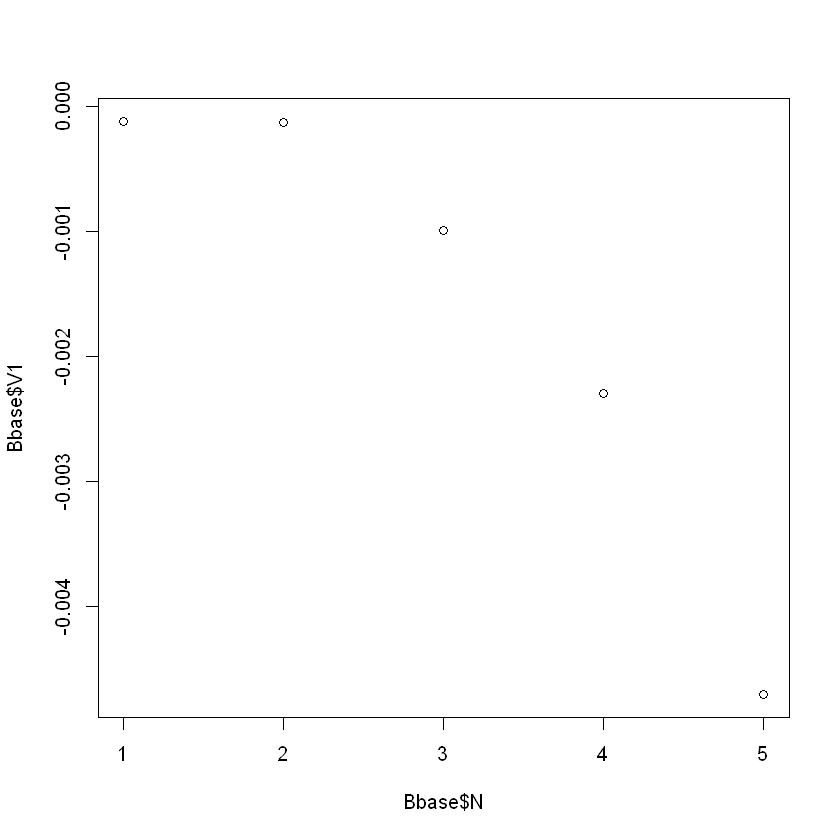

integer(0)

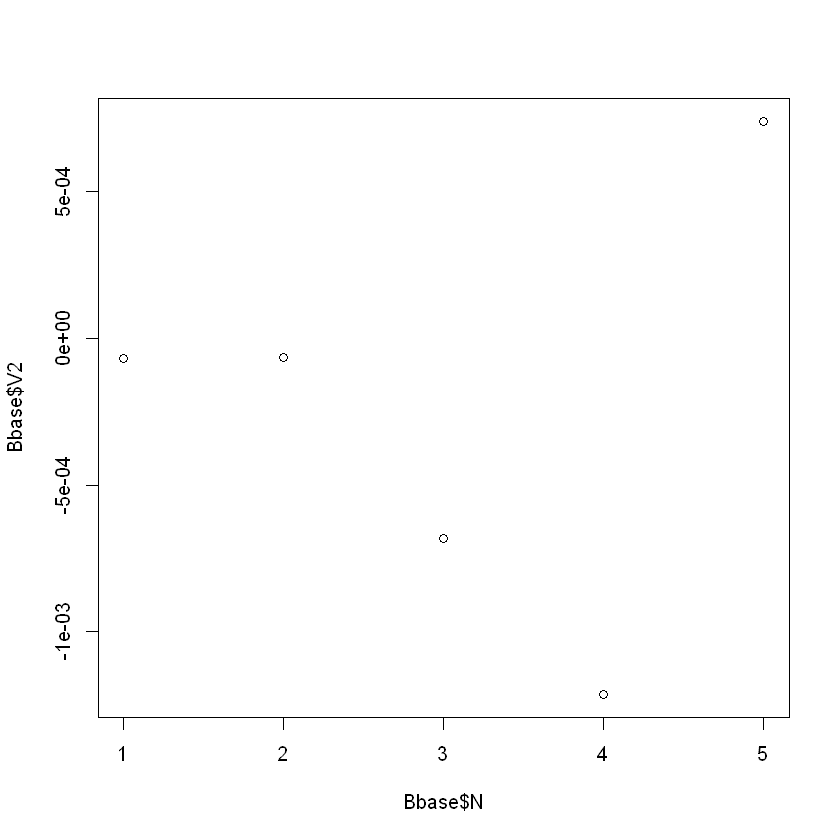

In [45]:
Bbase <- as.data.frame(B)
names(Bbase)
Bbase$N <- c(1,2,3,4,5)
Bbase
plot(Bbase$N ,Bbase$V1 ) + plot(Bbase$N ,Bbase$V2 )


In [46]:
Y <- MatofAlphas*A
Y

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1.260329e-04,3.919260e-03,-0.0049485433,-0.0140668740,0.053933595
-1.360437e-04,1.026291e-03,0.0006230461,-0.0323610012,0.117791964
-1.084636e-03,3.285195e-03,0.0373050223,-0.0664787941,-0.066290207
-2.614496e-03,6.973007e-03,0.0067415973,-0.0033207692,0.005808030
-5.620931e-03,-4.008065e-03,-0.0077122732,-0.0031047439,0.033563161
-2.732682e-04,3.440769e-04,0.0015951581,-0.0319337511,-0.131627132
-2.474242e-04,2.161951e-03,-0.0002854204,-0.0562287421,0.043709950
-2.589692e-03,-8.228323e-03,-0.0008510304,0.0344739619,-0.018251069
-4.751764e-03,2.831676e-03,-0.0009500040,0.0088456475,0.002317267


In [47]:
W <- MatofAlphas*B
W

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-6.715203e-07,6.194193e-06,-1.783415e-06,-7.495021e-05,3.105159e-05
-7.248592e-07,5.908739e-07,2.245408e-07,-1.724238e-04,6.781723e-05
-5.779087e-06,1.891409e-06,1.299680e-05,-3.542080e-04,-3.816575e-05
-1.393039e-05,4.014621e-06,2.348724e-06,-5.248308e-06,3.343900e-06
-2.994908e-05,-2.307593e-06,-2.686900e-06,-4.906891e-06,1.209589e-05
-4.318866e-07,1.980979e-07,5.557416e-07,-5.046968e-05,-4.743735e-05
-3.910415e-07,7.791495e-07,-9.943842e-08,-8.886669e-05,1.575271e-05
-4.092878e-06,-2.965421e-06,-4.534405e-06,5.448436e-05,-6.577537e-06
-7.509923e-06,1.020513e-06,-5.061750e-06,5.092770e-06,8.351243e-07


In [48]:
components <- princomp(delta_alpha)
summary(components)

Importance of components:
                            Comp.1      Comp.2       Comp.3       Comp.4
Standard deviation     0.005315312 0.001576646 0.0005743517 0.0003595245
Proportion of Variance 0.902110109 0.079372539 0.0105331395 0.0041272334
Cumulative Proportion  0.902110109 0.981482647 0.9920157869 0.9961430203
                             Comp.5
Standard deviation     0.0003475543
Proportion of Variance 0.0038569797
Cumulative Proportion  1.0000000000

In [49]:
cum_variance <- cumsum(components$sdev^2 / sum(components$sdev^2))
best_components <- components$scores[,1:2]

In [50]:
best_components

,Comp.1,Comp.2
2,-0.0002528322,-3.951757e-04
3,0.0001025732,3.980855e-04
4,0.0014439081,-1.801934e-04
5,-0.0022403413,9.448971e-04
6,-0.0010475918,-6.258394e-04
7,-0.0032262846,6.826125e-04
8,0.0016623384,-1.833866e-04
9,0.0022555963,1.334531e-03
10,0.0058457426,7.095740e-04
11,0.0001017914,1.451286e-04


In [51]:
librerias <- c("forecast","xts","rugarch","timeSeries","ggplot2","astsa","scales","lubridate","reshape2","quantmod","xtable","tseries")

In [52]:
if(length(setdiff(librerias, rownames(installed.packages()))) > 0){
  install.packages(setdiff(librerias, rownames(installed.packages())))}
invisible(sapply(librerias, require, character.only = TRUE,quietly = TRUE))

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
"package 'zoo' was built under R version 3.6.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'rugarch' was built under R version 3.6.3"
Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma

Warning message:
"package 'timeSeries' was built under R version 3.6.3"Warning message:
"package 'timeDate' was built under R version 3.6.2"
Attaching package: 'timeSeries'

The following object is masked from 'package:zoo':

    time<-


Attaching package: 'astsa'

The following object is masked from 'package:forecast':

    gas

Warning message:
"package 'scales' was built under R version 3.6.3"Warning messag

In [53]:
Arima_1 <- auto.arima(best_components[,1],stepwise = F,approximation = F)
Box.test(Arima_1$residuals)
Arima_2 <- auto.arima(best_components[,2],stepwise = F,approximation = F)
Box.test(Arima_2$residuals)


	Box-Pierce test

data:  Arima_1$residuals
X-squared = 0.016174, df = 1, p-value = 0.8988



	Box-Pierce test

data:  Arima_2$residuals
X-squared = 0.4558, df = 1, p-value = 0.4996


Simulaciones al futuro

In [54]:
future <- 52
simulations <- 1000
Sim_component_1 <- replicate(expr = simulate(object = Arima_1,nsim = future),n = simulations)
Sim_component_2 <- replicate(expr = simulate(object = Arima_2,nsim = future),n = simulations)
final <- list()
M3<-matrix(,nrow=simulations,ncol=2)
for (sim in 1:simulations){
        nam <- paste("S", sim, sep = "_")
        assign(nam, cbind(Sim_component_1[,sim] , Sim_component_2[,sim]))
        final <- append(final, Sim_component_1[nrow(Sim_component_1),sim] , Sim_component_2[nrow(Sim_component_2),sim])
}

In [55]:
S <- matrix(final, nrow=1000, ncol=2)
S

-0.00973265,-0.00973265
0.008418853,0.008418853
-0.00973265,-0.00973265
0.002380401,0.002380401
-0.00973265,-0.00973265
-0.0007737847,-0.0007737847
-0.00973265,-0.00973265
0.0006312584,0.0006312584
-0.00973265,-0.00973265
-0.004010197,-0.004010197
-0.00973265,-0.00973265


In [56]:
for (sim in 2:simulations){
    
}


$par
[1] 3.915928

$value
[1] 7.340577e-08

$counts
function gradient 
      NA       NA 

$convergence
[1] 0

$message
NULL